In [78]:
%matplotlib widget

import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import coordinates as coord
import kepler as kpl ##DEFINE KEPLERRRRRR
from scipy.integrate import odeint # this is new!
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs           # projection definitions
import cartopy.feature as cfeature   # optional land / ocean features

In [79]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

day2sec = 86400.0

## Earth's parameters

In [80]:
a = 6378137.0
c = 6356752.314245
e = np.sqrt(1 - c ** 2  / a ** 2)
mu = 3.986004418e14

## Satellite orbit parameters

In [81]:
R        = 6371000.0
altitude = R * 0.1
a = R + altitude
e = 0.01
i = 51.0  * deg2rad
w = 45.0  * deg2rad
W = 225.0 * deg2rad
M0 = 10.0 * deg2rad
t0 = 0.0
t = t0 + np.arange(0, 86400.0, 10)

## Functions for converting true, eccentric and mean anomalies

In [82]:
def E2nu(E, e):
    nu = np.sqrt((1 + e) / (1 - e)) 
    nu = 2 * np.arctan(nu * np.tan(E / 2))
    return nu

def nu2E(nu, e):
    cosnu = np.cos(nu)
    sinnu = np.sin(nu)
    sinE  = np.sqrt(1 - e * e) * sinnu / (1 + e * cosnu)
    cosE = (cosnu + e) / (1 + e * cosnu)
    E = v + np.arctan((sinE * cosnu - cosE * sinnu) / (cosE * cosnu + sinE * sinnu))

def E2M(E, e):
    return E - e * np.sin(E)

def M2E(M, e, E0):
    d   = np.array([1.0])
    eps = 1.0e-12
    E   = E0
    i   = 0
    while (d > eps).any():
        E_new = E - (E - e * np.sin(E) - M) / (1.0 - e * np.cos(E))
        d = np.abs(E_new - E)
        E = E_new
        i = i + 1
    return E, i

def nu2M(nu,e):
    E = nu2E(nu, e) # first, we compute the eccentric anomaly
    return E2M(E, e)

def M2nu(M,e):
    E, _ = M2E(M, e, M) # first, we compute the eccentric anomaly
    return E2nu(E, e)

## Our goal is to convert the orbital elements to a Cartesian state in ECI

#### First, we compute the true anomaly from the mean anomaly

In [83]:
nu = M2nu(M0, e)
print((M0,nu))

(0.17453292519943295, np.float64(0.1780491449096743))


#### Get specific angular momentum magnitude squared

In [84]:
h_squared =  mu * a * (1 - e ** 2)
h = np.sqrt(h_squared)

#### Get position and velocity in the perifocal coordinate system

In [85]:
r_orb     = h_squared / mu / (1 + e * np.cos(nu)) * np.array([np.cos(nu), np.sin(nu), 0])
v_orb     = mu / h * np.array((-np.sin(nu), e + np.cos(nu), 0))

#### Get rotation matrix to transorm the perifocal coordinate system to the ECI coordinate system

In [86]:
R_total   = coord.rotation(-W, 3) @ coord.rotation(-i, 1) @ coord.rotation(-w, 3)

#### Rotate radius-vector and velocity vector to the ECI coordinate system

In [87]:
r_eci     = R_total @ r_orb
v_eci     = R_total @ v_orb
print(r_eci)
print(v_eci)

[ -264556.15082893 -5335865.03598347  4428287.98196472]
[6356.10377508 2477.92815584 3386.43905855]


## IMPLEMENT HERE

In [88]:
(x2,y2, z2, vx2, vy2, vz2) = kpl.elem2coord(a, e, i, w, W, M0, t0, t0, mu)
print(x2, y2, z2)
print(vx2, vy2, vz2)

6912762.502780964 591458.8264099865 1812.3254843360278
-649.1017942994215 7588.860224131258 118.3199760460968


## IMPLEMENT HERE

In [89]:
(a2, e2, i2, w2, W2, M2) = kpl.coord2elem(r_eci[0], r_eci[1], r_eci[2], \
                                    v_eci[0], v_eci[1], v_eci[2], mu)

print(a2, e2, i2, w2, W2, M2)

7008099.999999996 0.009999999999999449 0.8901179185171081 0.7853981633974434 -2.3561944901923453 0.17453292519943792


## Keplerian orbit propagation

In [90]:
# R        = 6371000.0
# altitude = 38000000.0
# a        = R + altitude
# e        = 0.001
# i        = -51.0  * deg2rad
# w        = 45.0  * deg2rad
# W        = 225.0 * deg2rad
# M0       = 10.0  * deg2rad
# t0       = 0.0
# t1       = 1.5 * day2sec
# dt       = 60.0 # 60 seconds

# Molniya - Russia-US friendship orbit
a        = 26600000
e        = 0.74
i        = 63.4  * deg2rad
w        = 270.0 * deg2rad
W        = 170.0 * deg2rad
M0       = 10.0  * deg2rad
t0       = 0.0
t1       = day2sec 
dt       = 60.0*10 # 60 seconds

# Tundra orbit
# a        = 42164000.0
# e        = 0.3
# i        = (63.4)  * deg2rad
# w        = 270.0 * deg2rad
# W        = 170.0 * deg2rad
# M0       = 10.0  * deg2rad
# t0       = 0.0
# t1       = day2sec 
# dt       = 60.0 # 60 seconds

# t        = np.arange(t0, t1, dt)

#### Mean motion

In [91]:
n = np.sqrt(mu / (a ** 3))
print(n)

0.0001455279571302874


#### Mean anomaly

In [92]:
M = M0 + n * (t - t0)
print(M)

[ 0.17453293  0.1759882   0.17744348 ... 12.74378258 12.74523786
 12.74669314]


#### True anomaly

In [93]:
nu = M2nu(M, e)
print(nu)

[1.31516681 1.32187929 1.32853756 ... 1.32839393 1.33499969 1.34155235]


#### Specific angular momentum

In [94]:
h_squared =  mu * a * (1 - e ** 2)
h         =  np.sqrt(h_squared)

#### Position and velocity in the perifocal coordinate system

In [95]:
r_orb     = h_squared / mu / (1 + e * np.cos(nu)) * np.array([np.cos(nu), np.sin(nu), np.zeros(nu.shape)])
v_orb     = mu / h * np.array((-np.sin(nu), e + np.cos(nu), np.zeros(nu.shape)))

#### Rotation matrix from perifocal coordinate system to ECI coordinate system

In [96]:
R_total   = coord.rotation(-W, 3) @ coord.rotation(-i, 1) @ coord.rotation(-w, 3)

#### Apply rotation

In [97]:
r_eci     = R_total @ r_orb
v_eci     = R_total @ v_orb

#### Function that plots a sphere

In [98]:
def plot_sphere(ax, R, npts):
    lon = np.linspace(0, 2*pi, npts)
    lat = np.linspace(-pi/2, pi/2, npts)
    lon, lat = np.meshgrid(lon, lat)
    x_sphere, y_sphere, z_sphere  = coord.sph2cart(lon, lat, R)
    ax.plot_surface(x_sphere, y_sphere, z_sphere)
    plt.show()

#### Plot orbit

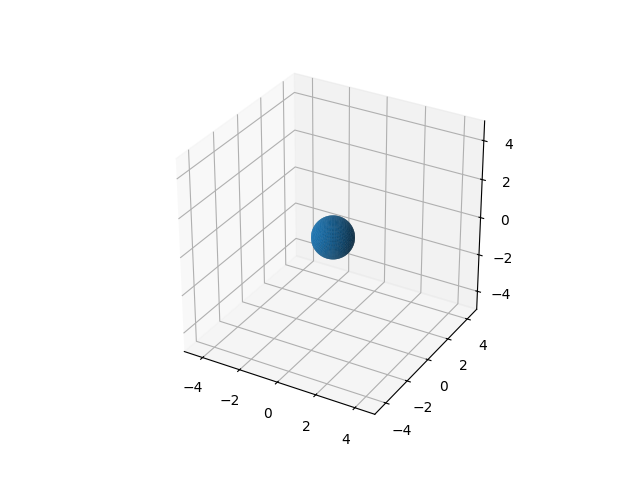

Text(0.09988820053828747, 0.013382481333816013, 'z [$R_{Earth}$]')

In [99]:

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.set_aspect('equal', 'box')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
ax.set_zlim((-5,5))

# Plot sphere
plot_sphere(ax, 1, 100)

# Plot orbit
plt.plot(r_eci[0,:]/R, r_eci[1,:]/R, r_eci[2,:]/R,'-k')

# setting title and labels 
ax.set_xlabel(r'x [$R_{Earth}]$') 
ax.set_ylabel(r'y [$R_{Earth}$]') 
ax.set_zlabel(r'z [$R_{Earth}$]') 

## Numerical integration example

#### Define a function that returns the derivative of the state vector

In [100]:
# function that returns dy/dt
def two_body_ode(y,t):
    r_vec = y[:3]

    # Create the derivative vector and copy the velocities into it
    y_dot = np.zeros_like(y)
    y_dot[:3] = y[3:]

    # Calculate the accelerations
    r_mag     = np.sqrt(r_vec[0] ** 2 + r_vec[1] ** 2 + r_vec[2] ** 2)
    a_vec     = - mu * r_vec / (r_mag ** 3)
    y_dot[3:] = a_vec
    
    return y_dot

#### Create initial conditions 

In [101]:
# initial condition
state_initial = np.hstack((r_eci[:,0], v_eci[:,0]))
print(state_initial)

[-9.45936213e+06  2.83334365e+06 -2.29189954e+06 -6.06029557e+03
 -1.46310864e+03  4.97888527e+03]


#### Integrate using ODEINT function from the scipy numerical package

In [102]:
# absolute tolerance
atol = 1e-7

# relative tolerance
rtol = 1e-7

# solve ODE
state = odeint(two_body_ode, state_initial, t, rtol = rtol, atol = atol)

# extract position and velocity
r_eci_num = state[:,:3]
v_eci_num = state[:,3:]

#### Plot orbit

Text(0.5, 0, 'z [$R_{Earth}$]')

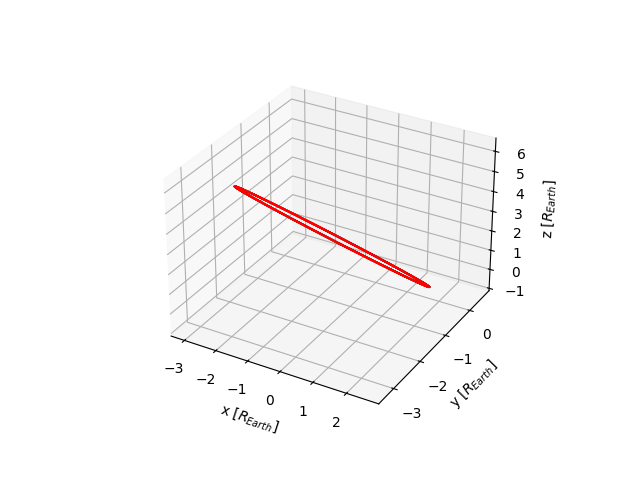

In [103]:
ax = plt.figure().add_subplot(projection='3d')

# Plot sphere
# plot_sphere(1, 100)

# Plot orbit
plt.plot(r_eci_num[:,0]/R, r_eci_num[:,1]/R, r_eci_num[:,2]/R,'-k')
plt.plot(r_eci[0,:]/R, r_eci[1,:]/R, r_eci[2,:]/R,'-r')


# setting title and labels 
ax.set_xlabel(r'x [$R_{Earth}]$') 
ax.set_ylabel(r'y [$R_{Earth}$]') 
ax.set_zlabel(r'z [$R_{Earth}$]') 

#### Compute differences with analytical solution for position and velocity

Text(0, 0.5, 'Position difference [m]')

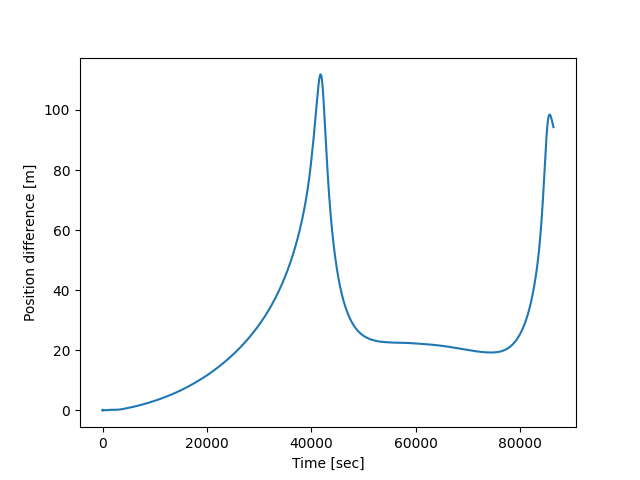

In [104]:
r_diff     = r_eci - r_eci_num.T
r_diff_mag = np.sqrt(r_diff[0,:]**2 + r_diff[1,:]**2 + r_diff[2,:]**2)
plt.figure()
plt.plot(t,r_diff_mag)
plt.xlabel("Time [sec]")
plt.ylabel("Position difference [m]")

Text(0, 0.5, 'Velocity difference [m/s]')

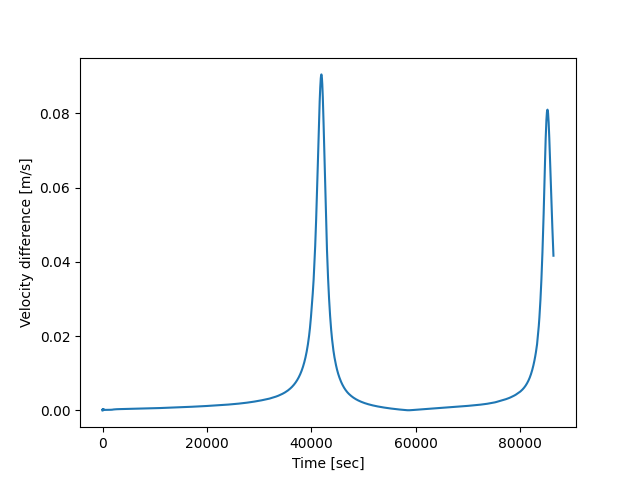

In [105]:
v_diff     = v_eci - v_eci_num.T
v_diff_mag = np.sqrt(v_diff[0,:]**2 + v_diff[1,:]**2 + v_diff[2,:]**2)
plt.figure()
plt.plot(t,v_diff_mag)
plt.xlabel("Time [sec]")
plt.ylabel("Velocity difference [m/s]")

## Now, let's plot some orbital tracks on the map

#### Define Julian date to get the Earth rotation angle

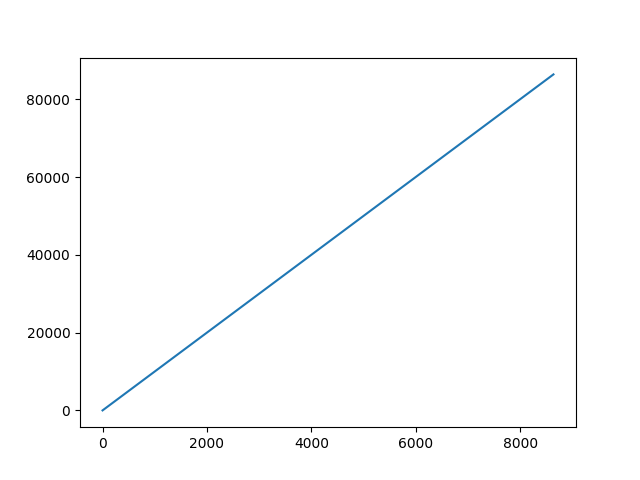

In [106]:
JD_J2000 = coord.gregorian2JD(1.0,1.5,2000.0)
JD_J2024 = coord.gregorian2JD(1.0,1.0,2024.0)

d = JD_J2024 - JD_J2000 + t / 86400.0
S = (280.4606 + 360.9856473 * (d)) * deg2rad
plt.figure()
plt.plot(t)

#### Compute rotation matrices for a sequence of times

In [107]:
R = [coord.rotation(S[i],3) for i in range(len(S))]

### Rotate from ECI to ECEF

In [109]:
r_ECEF = np.array([np.dot(R[i],r_eci[:,i].T) for i in range(len(S))])

x_ECEF = r_ECEF[:,0]
y_ECEF = r_ECEF[:,1]
z_ECEF = r_ECEF[:,2]

#### Get latitude and longitude

In [110]:
(lon, lat, _) = coord.cart2sph(x_ECEF,y_ECEF,z_ECEF)

#### Plot lat and lot of the track

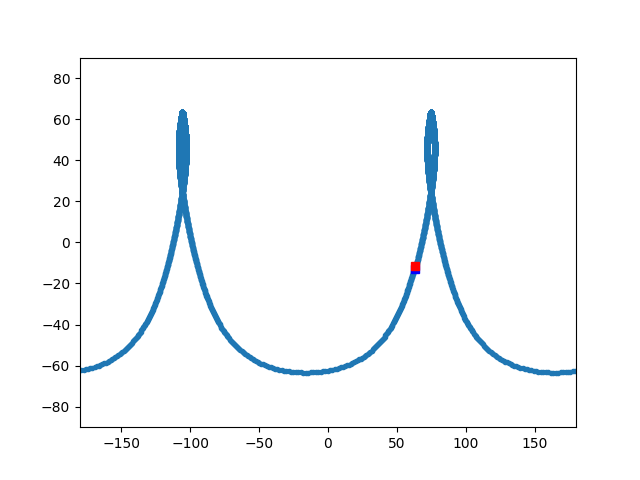

Text(35.472222222222214, 0.5, 'Latitude [deg]')

In [111]:
fig = plt.figure()
plt.plot(lon * rad2deg, lat * rad2deg,'.')
plt.plot(lon[0] * rad2deg,  lat[0] * rad2deg,'sb')
plt.plot(lon[-1] * rad2deg, lat[-1] * rad2deg,'sr')
plt.xlim((-180,180))
plt.ylim((-90,90))
plt.show()
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")

#### Can go a bit more fancy and plot it on an actual map

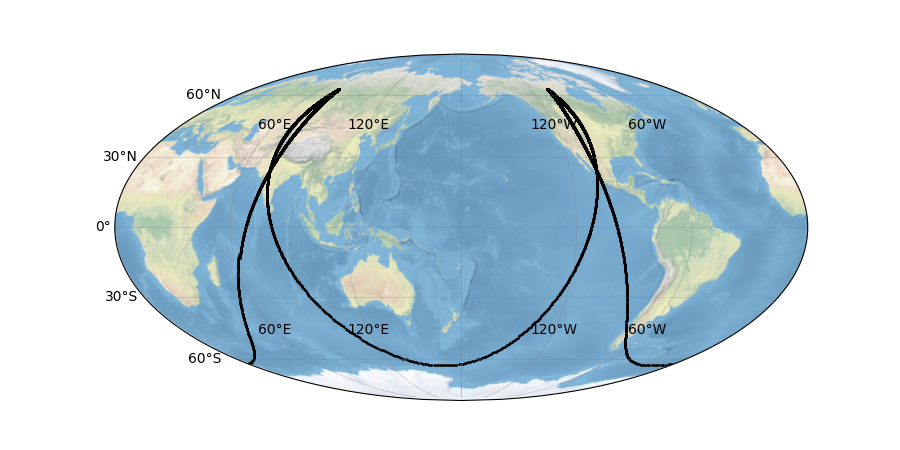

In [112]:
# Basemap expected degrees, so if lon/lat were in radians convert them.
lon_deg = np.degrees(lon)            # or lon * 180/np.pi
lat_deg = np.degrees(lat)

# ---- build the map -----------------------------------------------------
fig = plt.figure(figsize=(9, 4.5))
ax  = plt.axes(                       # GeoAxes replaces the “Basemap” object
        projection=ccrs.Mollweide(central_longitude=180))

ax.set_global()                      # make sure the whole world is shown
ax.stock_img()                       # quick shaded-relief background
# ax.add_feature(cfeature.LAND, zorder=0)          # ↳ use these instead …
# ax.add_feature(cfeature.OCEAN, zorder=0)         #   … if you want simple fills
# ax.coastlines()

# ---- plot the ground track --------------------------------------------
ax.plot(lon_deg, lat_deg, '.k', ms=2,          # just like plt.plot
        transform=ccrs.PlateCarree())          # <-- lon/lat CRS
                                             # Geodetic() also works

# (optional) nice gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5)
gl.top_labels   = False
gl.right_labels = False

plt.show()


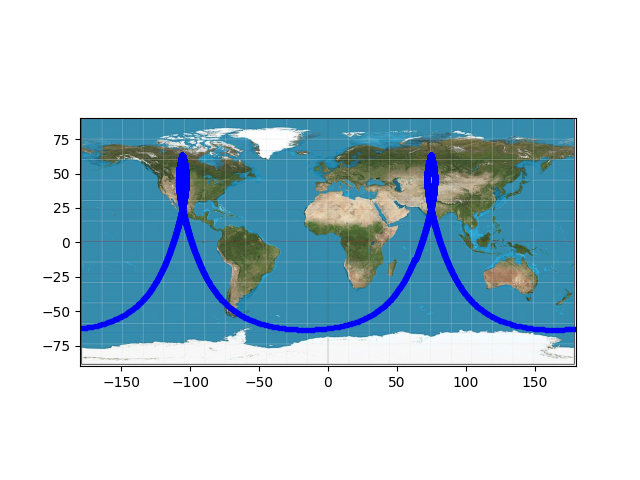

In [113]:
plt.figure()
plt.scatter(np.array(lon)*rad2deg, np.array(lat)*rad2deg, c='blue', marker='.')
img = plt.imread("Earth.jpg")
plt.imshow(img, extent=[-180, 180, -90, 90])


NameError: name 'Basemap' is not defined

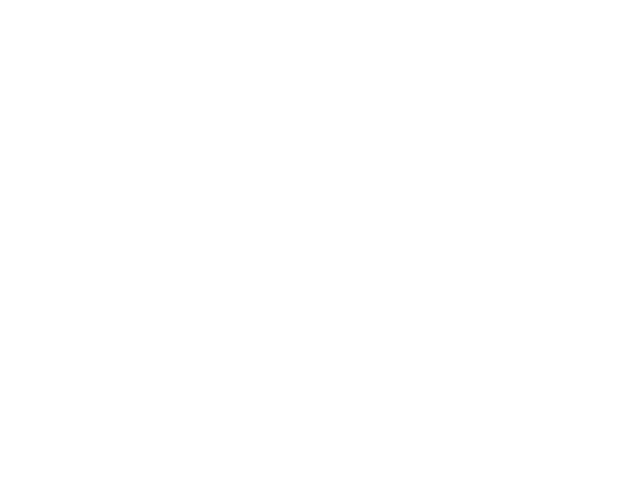

In [114]:
plt.figure()
map = Basemap(projection='moll',lon_0 = 180.0)
map.shadedrelief()
x_track, y_track = map(lon * rad2deg, lat * rad2deg)
map.plot(x_track, y_track,'.k')
plt.show()